# PySpark Analiza i SparkML ALS Modelovanje

Ovaj notebook demonstrira:
1. **EDA analize** koristeći Spark DataFrame API i SparkSQL (replicirane iz `mongodb_analytics.ipynb`)
2. **Poređenje sintakse** Pandas vs PySpark
3. **SparkML ALS model** za implicit feedback preporuke (poređenje sa `implicit` bibliotekom iz produkcije)

Podaci: `filtered_interactions.csv`, `products.csv`, `product_product.csv` iz `../../data/`

---
## Sekcija 1: Setup i Okruženje

In [2]:
from pyspark.sql import SparkSession

# local[*] - koristimo sve korove procesora
# "spark.driver.memory", "4g" - glavnom procesu dodeljujemo 4gb memorije
# "spark.sql.shuffle.partitions", "8" - ako radimo group by na 800k redova, podelicemo to na 100k
spark = SparkSession.builder \
    .appName("PA-Recommender-Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print(f"Spark verzija: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Spark verzija: 3.5.4
Spark UI: http://192.168.56.1:4040


In [3]:
# Konstante iz shared.py
INTERACTION_WEIGHTS = {
    'purchase': 1.0,
    'initiate_checkout': 0.7,
    'add_to_cart': 0.5,
    'add_to_wishlist': 0.3,
    'content_view': 0.1
}

DECAY_SCALE = 25           # shared.py:48 - INTERACTION_DECAY_SCALE
REPEAT_DECAY_FACTOR = 0.8  # shared.py:52 - INTERACTION_REPEAT_DECAY_FACTOR

import os
DATA_DIR = os.path.join('..', '..', 'data')

print("Konstante učitane:")
for action, weight in INTERACTION_WEIGHTS.items():
    print(f"  {action}: {weight}")

Konstante učitane:
  purchase: 1.0
  initiate_checkout: 0.7
  add_to_cart: 0.5
  add_to_wishlist: 0.3
  content_view: 0.1


---
## Sekcija 2: Učitavanje podataka

In [4]:
from pyspark.sql.types import StructType, StructField, LongType, StringType, DoubleType, IntegerType
from pyspark.sql.functions import col

# filtered_interactions.csv: id, action, user_uid, created, product_id
# product_id dolazi kao double (38420.0) pa castujemo u int
interactions_schema = StructType([
    StructField("id", LongType(), True),
    StructField("action", StringType(), True),
    StructField("user_uid", StringType(), True),
    StructField("created", LongType(), True),
    StructField("product_id", DoubleType(), True)
])

interactions_df = spark.read.csv(
    os.path.join(DATA_DIR, 'filtered_interactions.csv'),
    header=True,
    schema=interactions_schema
).withColumn("product_id", col("product_id").cast(IntegerType()))

print(f"Interactions: {interactions_df.count():,} redova")
interactions_df.printSchema()
interactions_df.show(5, truncate=False)

Interactions: 732,057 redova
root
 |-- id: long (nullable = true)
 |-- action: string (nullable = true)
 |-- user_uid: string (nullable = true)
 |-- created: long (nullable = true)
 |-- product_id: integer (nullable = true)

+-------+-----------+----------------------------------------+----------+----------+
|id     |action     |user_uid                                |created   |product_id|
+-------+-----------+----------------------------------------+----------+----------+
|2418549|add_to_cart|S3k0Z3hqVEZybXFJY2YyVDIwMjU1MTUxNjM1NA==|1758321537|38420     |
|2418547|add_to_cart|S3k0Z3hqVEZybXFJY2YyVDIwMjU1MTUxNjM1NA==|1758321536|38420     |
|2418265|add_to_cart|ZXdFYTRTZGFLUDdUSVdjbjIwMjU4ODIyNTc1Mw==|1758319902|97777     |
|2417928|add_to_cart|ZDJ1NUhtTlM5NDkya0g4OTIwMjU4MTYxODE2MjE=|1758318270|77269     |
|2417767|add_to_cart|bVJEWmp4bFpockdBNVFGNzIwMjU4MTkyMzMwMzA=|1758317488|44607     |
+-------+-----------+----------------------------------------+----------+----------+
only showi

In [7]:
# products.csv: id, text, price
# multiLine=true jer text kolona sadrži HTML sa newline karakterima
products_df = spark.read.csv(
    os.path.join(DATA_DIR, 'products.csv'),
    header=True,
    multiLine=True,
    inferSchema=True
)

print(f"Products: {products_df.count():,} redova")
products_df.printSchema()
products_df.select("id", "price").show(5)

Products: 268,769 redova
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- price: string (nullable = true)

+--------------------+--------------------+
|                  id|               price|
+--------------------+--------------------+
|                   1|                NULL|
| <div class=""row"">|                NULL|
|<div class=""col-...|                NULL|
|<div class=""col-...|                NULL|
|<div class=""col-...| svesnog aktivira...|
+--------------------+--------------------+
only showing top 5 rows



In [8]:
# product_product.csv: product_to_recommend_id, product_for_recommendation_id, interaction_weight
product_product_df = spark.read.csv(
    os.path.join(DATA_DIR, 'product_product.csv'),
    header=True,
    inferSchema=True
)

print(f"Product-Product: {product_product_df.count():,} redova")
product_product_df.printSchema()
product_product_df.show(5)

Product-Product: 1,165,379 redova
root
 |-- product_to_recommend_id: integer (nullable = true)
 |-- product_for_recommendation_id: integer (nullable = true)
 |-- interaction_weight: double (nullable = true)

+-----------------------+-----------------------------+-------------------+
|product_to_recommend_id|product_for_recommendation_id| interaction_weight|
+-----------------------+-----------------------------+-------------------+
|                      1|                            1|  4.899985842635101|
|                      1|                            6| 0.4999999689426045|
|                      1|                           94|0.49999960904293406|
|                      1|                          713|0.09997802023515588|
|                      1|                          882|0.09960094704149075|
+-----------------------+-----------------------------+-------------------+
only showing top 5 rows



In [9]:
# Registracija kao SQL temp views
interactions_df.createOrReplaceTempView("interactions")
products_df.createOrReplaceTempView("products")
product_product_df.createOrReplaceTempView("product_product")

print("SQL temp views registrovani:")
for table in spark.catalog.listTables():
    print(f"  {table.name} ({table.tableType})")

SQL temp views registrovani:
  interactions (TEMPORARY)
  product_product (TEMPORARY)
  products (TEMPORARY)


---
## Sekcija 3: EDA sa Spark DataFrame API i SparkSQL

Svaka analiza je implementirana na dva načina:
- **DataFrame API** - programski pristup
- **SparkSQL** - SQL pristup na istim podacima

### 3.1 Broj interakcija po tipu akcije

=== DataFrame API ===
+-----------------+------+
|           action| count|
+-----------------+------+
|     content_view|704541|
|      add_to_cart| 16488|
|initiate_checkout|  7840|
|         purchase|  2581|
|  add_to_wishlist|   607|
+-----------------+------+

=== SparkSQL ===
+-----------------+------+
|           action| count|
+-----------------+------+
|     content_view|704541|
|      add_to_cart| 16488|
|initiate_checkout|  7840|
|         purchase|  2581|
|  add_to_wishlist|   607|
+-----------------+------+



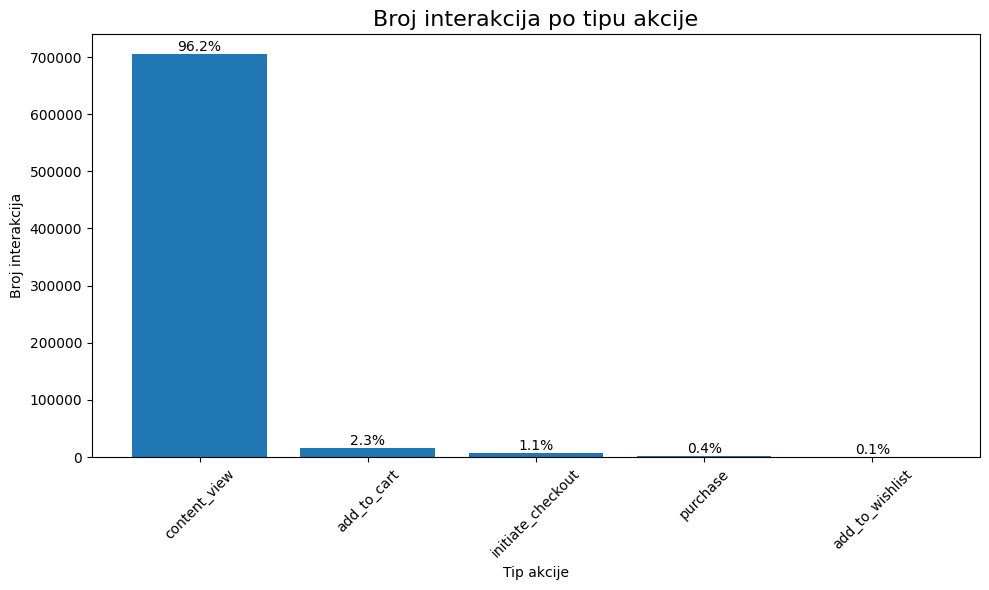

Ukupno interakcija: 732,057


In [8]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, countDistinct, sum as spark_sum, when, max as spark_max

# DataFrame API
action_counts_df = interactions_df.groupBy("action").agg(
    count("*").alias("count")
).orderBy(col("count").desc())

print("=== DataFrame API ===")
action_counts_df.show()

# SparkSQL
print("=== SparkSQL ===")
action_counts_sql = spark.sql("""
    SELECT action, COUNT(*) as count
    FROM interactions
    GROUP BY action
    ORDER BY count DESC
""")
action_counts_sql.show()

# Vizualizacija
pdf = action_counts_df.toPandas()
total = pdf['count'].sum()

plt.figure(figsize=(10, 6))
bars = plt.bar(pdf['action'], pdf['count'])
plt.title('Broj interakcija po tipu akcije', fontsize=16)
plt.xlabel('Tip akcije')
plt.ylabel('Broj interakcija')
plt.xticks(rotation=45)
for bar, val in zip(bars, pdf['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val/total*100:.1f}%', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

print(f"Ukupno interakcija: {total:,}")

### 3.2 Top 20 najaktivnijih korisnika

=== DataFrame API: Top 20 najaktivnijih korisnika ===
+--------------------+------------------+---------------+-----------------+------------------+
|            user_uid|total_interactions|unique_products|add_to_cart_count|content_view_count|
+--------------------+------------------+---------------+-----------------+------------------+
|VlRHS1NYQkJKY2w1U...|              2144|            856|              175|              1958|
|N0RSOWdsdDFqa2JDZ...|              1740|            840|              134|              1581|
|QVVSN09Cb0ZBOFRXR...|              1706|           1270|                1|              1703|
|TXB6dERiVTROSlJhY...|              1618|           1159|               34|              1541|
|b1lSRnhJRGNtNm1yW...|              1432|            986|                1|              1430|
|TWFpbjMyNGI1YlNhQ...|              1410|            259|                0|              1410|
|Y2hwdE5hZmNUUUNnM...|               862|            658|                0|               8

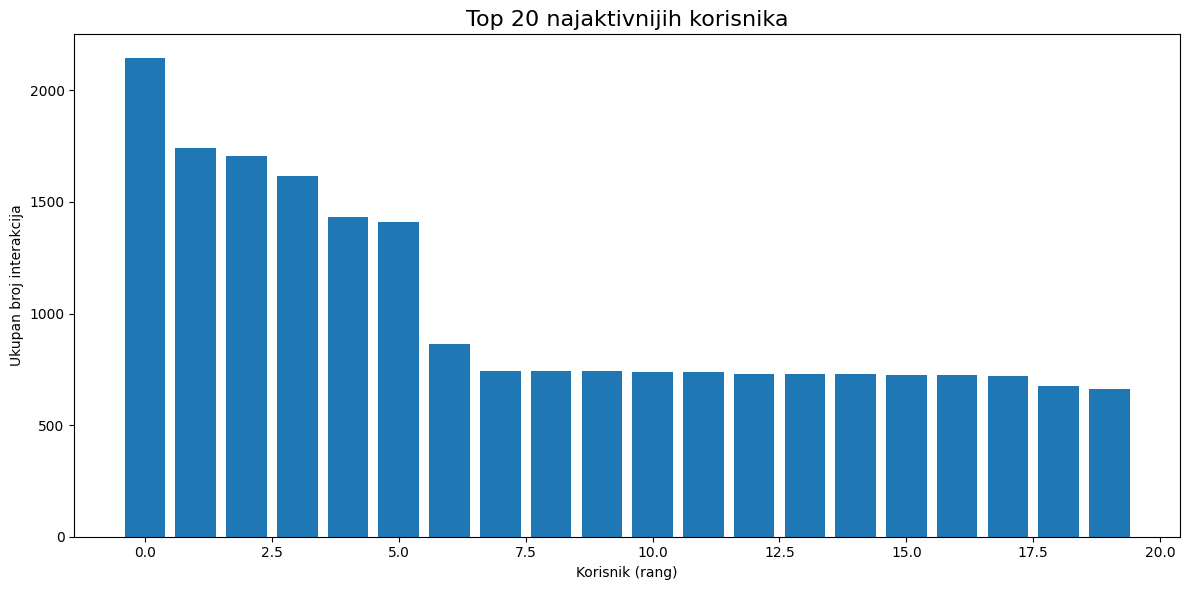

Najaktivniji korisnik: 2,144 interakcija
Prosečan broj interakcija top 20: 1016


In [9]:
# DataFrame API
top_users_df = interactions_df.groupBy("user_uid").agg(
    count("*").alias("total_interactions"),
    countDistinct("product_id").alias("unique_products"),
    spark_sum(when(col("action") == "add_to_cart", 1).otherwise(0)).alias("add_to_cart_count"),
    spark_sum(when(col("action") == "content_view", 1).otherwise(0)).alias("content_view_count")
).orderBy(col("total_interactions").desc()).limit(20)

print("=== DataFrame API: Top 20 najaktivnijih korisnika ===")
top_users_df.show(20, truncate=20)

# SparkSQL
print("=== SparkSQL ===")
spark.sql("""
    SELECT 
        user_uid,
        COUNT(*) as total_interactions,
        COUNT(DISTINCT product_id) as unique_products,
        SUM(CASE WHEN action = 'add_to_cart' THEN 1 ELSE 0 END) as add_to_cart_count,
        SUM(CASE WHEN action = 'content_view' THEN 1 ELSE 0 END) as content_view_count
    FROM interactions
    GROUP BY user_uid
    ORDER BY total_interactions DESC
    LIMIT 20
""").show(20, truncate=20)

# Vizualizacija
pdf_users = top_users_df.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(range(len(pdf_users)), pdf_users['total_interactions'])
plt.title('Top 20 najaktivnijih korisnika', fontsize=16)
plt.xlabel('Korisnik (rang)')
plt.ylabel('Ukupan broj interakcija')
plt.tight_layout()
plt.show()

print(f"Najaktivniji korisnik: {pdf_users.iloc[0]['total_interactions']:,} interakcija")
print(f"Prosečan broj interakcija top 20: {pdf_users['total_interactions'].mean():.0f}")

### 3.3 Distribucija interakcija po satima

=== DataFrame API ===
+----+------------------+
|hour|total_interactions|
+----+------------------+
|   0|             21655|
|   1|             12344|
|   2|              6074|
|   3|              3969|
|   4|              3969|
|   5|              5938|
|   6|             12897|
|   7|             23666|
|   8|             34151|
|   9|             38593|
|  10|             41941|
|  11|             43269|
|  12|             43501|
|  13|             43152|
|  14|             43270|
|  15|             39996|
|  16|             36896|
|  17|             35866|
|  18|             36915|
|  19|             38563|
|  20|             41950|
|  21|             47026|
|  22|             43933|
|  23|             32523|
+----+------------------+

=== SparkSQL ===
+----+------------------+
|hour|total_interactions|
+----+------------------+
|   0|             21655|
|   1|             12344|
|   2|              6074|
|   3|              3969|
|   4|              3969|
|   5|              5938

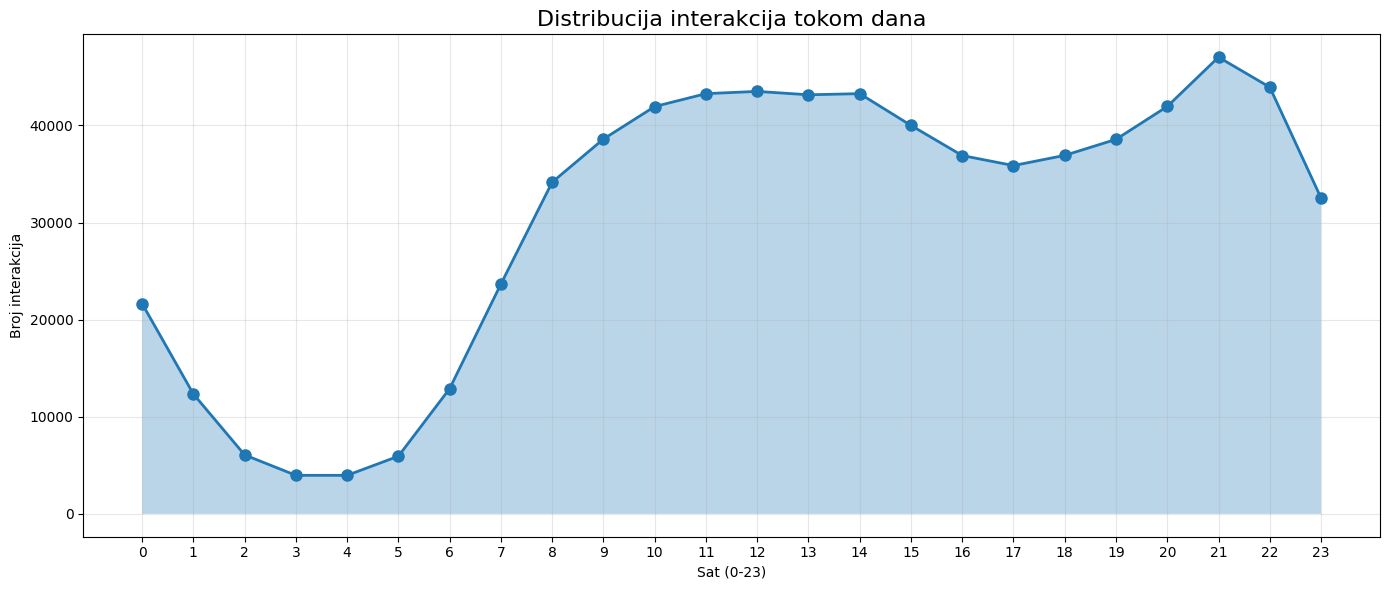

Peak: 21h sa 47,026 interakcija


In [10]:
from pyspark.sql.functions import from_unixtime, hour

# DataFrame API
hourly_df = interactions_df \
    .withColumn("hour", hour(from_unixtime(col("created")))) \
    .groupBy("hour").agg(count("*").alias("total_interactions")) \
    .orderBy("hour")

print("=== DataFrame API ===")
hourly_df.show(24)

# SparkSQL
print("=== SparkSQL ===")
spark.sql("""
    SELECT 
        HOUR(FROM_UNIXTIME(created)) as hour,
        COUNT(*) as total_interactions
    FROM interactions
    GROUP BY HOUR(FROM_UNIXTIME(created))
    ORDER BY hour
""").show(24)

# Vizualizacija
pdf_hourly = hourly_df.toPandas()
plt.figure(figsize=(14, 6))
plt.plot(pdf_hourly['hour'], pdf_hourly['total_interactions'], marker='o', linewidth=2, markersize=8)
plt.fill_between(pdf_hourly['hour'], pdf_hourly['total_interactions'], alpha=0.3)
plt.title('Distribucija interakcija tokom dana', fontsize=16)
plt.xlabel('Sat (0-23)')
plt.ylabel('Broj interakcija')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

peak = pdf_hourly.loc[pdf_hourly['total_interactions'].idxmax()]
print(f"Peak: {int(peak['hour'])}h sa {peak['total_interactions']:,} interakcija")

### 3.5 Konverziona funel analiza

=== DataFrame API: Konverziona Funel ===
Ukupno korisnika:       282,561
Sa pregledima:          281,941
Sa korpom:              6,141
Sa kupovinom:           2,340
Pregled + Korpa:        5,595

=== SparkSQL ===
+-----------+---------------+---------------+-------------------+-------------+
|total_users|users_with_view|users_with_cart|users_with_purchase|view_and_cart|
+-----------+---------------+---------------+-------------------+-------------+
|     282561|         281941|           6141|               2340|         5595|
+-----------+---------------+---------------+-------------------+-------------+



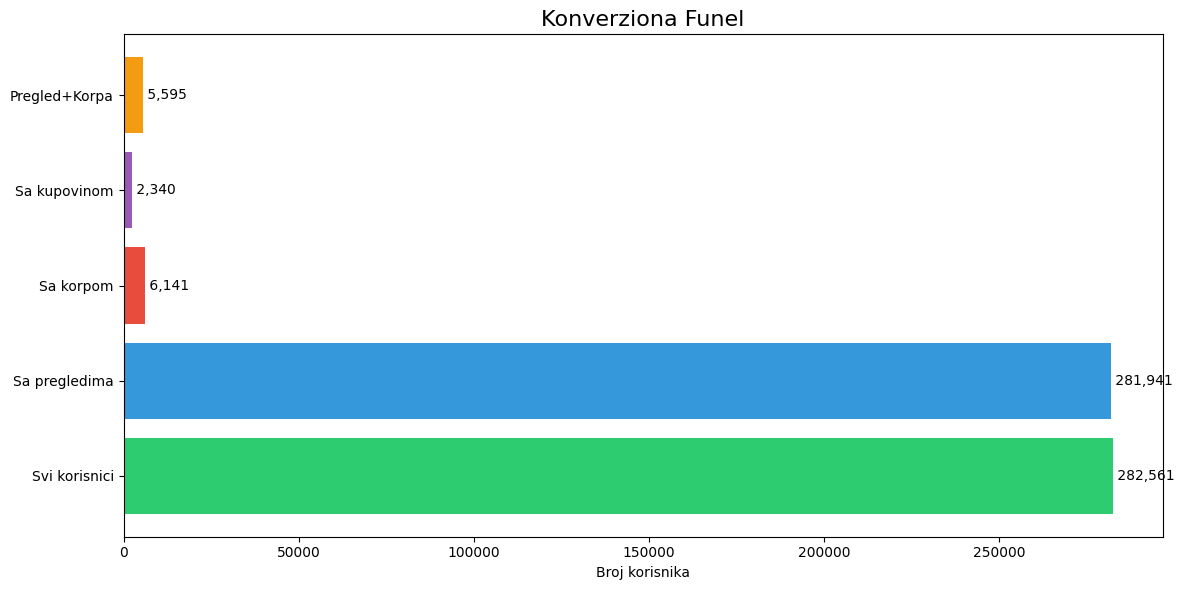

Konverzija (pregled -> korpa): 1.98%


In [12]:
# DataFrame API - per-user conditional max, then aggregate
funnel_df = interactions_df.groupBy("user_uid").agg(
    spark_max(when(col("action") == "content_view", 1).otherwise(0)).alias("has_view"),
    spark_max(when(col("action") == "add_to_cart", 1).otherwise(0)).alias("has_cart"),
    spark_max(when(col("action") == "purchase", 1).otherwise(0)).alias("has_purchase")
)

funnel_stats = funnel_df.agg(
    count("*").alias("total_users"),
    spark_sum("has_view").alias("users_with_view"),
    spark_sum("has_cart").alias("users_with_cart"),
    spark_sum("has_purchase").alias("users_with_purchase"),
    spark_sum(when((col("has_view") == 1) & (col("has_cart") == 1), 1).otherwise(0)).alias("view_and_cart")
).collect()[0]

print("=== DataFrame API: Konverziona Funel ===")
print(f"Ukupno korisnika:       {funnel_stats['total_users']:,}")
print(f"Sa pregledima:          {funnel_stats['users_with_view']:,}")
print(f"Sa korpom:              {funnel_stats['users_with_cart']:,}")
print(f"Sa kupovinom:           {funnel_stats['users_with_purchase']:,}")
print(f"Pregled + Korpa:        {funnel_stats['view_and_cart']:,}")

# SparkSQL
print("\n=== SparkSQL ===")
spark.sql("""
    SELECT 
        COUNT(*) as total_users,
        SUM(has_view) as users_with_view,
        SUM(has_cart) as users_with_cart,
        SUM(has_purchase) as users_with_purchase,
        SUM(CASE WHEN has_view = 1 AND has_cart = 1 THEN 1 ELSE 0 END) as view_and_cart
    FROM (
        SELECT 
            user_uid,
            MAX(CASE WHEN action = 'content_view' THEN 1 ELSE 0 END) as has_view,
            MAX(CASE WHEN action = 'add_to_cart' THEN 1 ELSE 0 END) as has_cart,
            MAX(CASE WHEN action = 'purchase' THEN 1 ELSE 0 END) as has_purchase
        FROM interactions
        GROUP BY user_uid
    )
""").show()

# Vizualizacija
stages = ['Svi korisnici', 'Sa pregledima', 'Sa korpom', 'Sa kupovinom', 'Pregled+Korpa']
values = [funnel_stats['total_users'], funnel_stats['users_with_view'],
          funnel_stats['users_with_cart'], funnel_stats['users_with_purchase'],
          funnel_stats['view_and_cart']]

plt.figure(figsize=(12, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']
plt.barh(stages, values, color=colors)
plt.title('Konverziona Funel', fontsize=16)
plt.xlabel('Broj korisnika')
for i, v in enumerate(values):
    plt.text(v, i, f' {v:,}', va='center')
plt.tight_layout()
plt.show()

if funnel_stats['users_with_view'] > 0:
    conv_rate = funnel_stats['view_and_cart'] / funnel_stats['users_with_view'] * 100
    print(f"Konverzija (pregled -> korpa): {conv_rate:.2f}%")

### 3.6 Segmentacija korisnika po aktivnosti

=== DataFrame API ===
+-----------------------+----------+
|segment                |user_count|
+-----------------------+----------+
|500+ (Power korisnici) |26        |
|100-499 (Super aktivni)|279       |
|50-99 (Veoma aktivni)  |660       |
|20-49 (Aktivni)        |2880      |
|10-19 (Umereno aktivni)|6427      |
|5-9 (Slabo aktivni)    |15950     |
|1-4 (Neaktivni)        |256339    |
+-----------------------+----------+

=== SparkSQL ===
+-----------------------+----------+
|segment                |user_count|
+-----------------------+----------+
|500+ (Power korisnici) |26        |
|100-499 (Super aktivni)|279       |
|50-99 (Veoma aktivni)  |660       |
|20-49 (Aktivni)        |2880      |
|10-19 (Umereno aktivni)|6427      |
|5-9 (Slabo aktivni)    |15950     |
|1-4 (Neaktivni)        |256339    |
+-----------------------+----------+



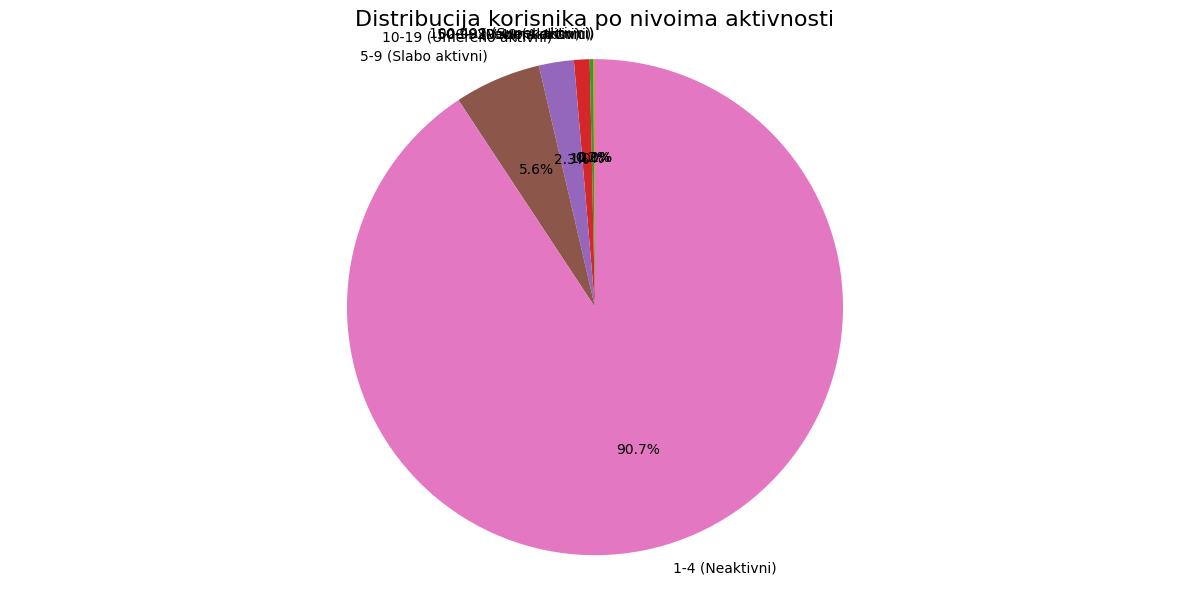

500+ (Power korisnici): 26 korisnika (0.0%)
100-499 (Super aktivni): 279 korisnika (0.1%)
50-99 (Veoma aktivni): 660 korisnika (0.2%)
20-49 (Aktivni): 2880 korisnika (1.0%)
10-19 (Umereno aktivni): 6427 korisnika (2.3%)
5-9 (Slabo aktivni): 15950 korisnika (5.6%)
1-4 (Neaktivni): 256339 korisnika (90.7%)


In [13]:
# DataFrame API - when/otherwise bucketiranje
user_counts = interactions_df.groupBy("user_uid").agg(count("*").alias("total"))

segments_df = user_counts.withColumn("segment",
    when(col("total") < 5, "1-4 (Neaktivni)")
    .when(col("total") < 10, "5-9 (Slabo aktivni)")
    .when(col("total") < 20, "10-19 (Umereno aktivni)")
    .when(col("total") < 50, "20-49 (Aktivni)")
    .when(col("total") < 100, "50-99 (Veoma aktivni)")
    .when(col("total") < 500, "100-499 (Super aktivni)")
    .otherwise("500+ (Power korisnici)")
).groupBy("segment").agg(count("*").alias("user_count")).orderBy("user_count")

print("=== DataFrame API ===")
segments_df.show(truncate=False)

# SparkSQL
print("=== SparkSQL ===")
spark.sql("""
    SELECT segment, COUNT(*) as user_count FROM (
        SELECT user_uid, 
            CASE 
                WHEN cnt < 5   THEN '1-4 (Neaktivni)'
                WHEN cnt < 10  THEN '5-9 (Slabo aktivni)'
                WHEN cnt < 20  THEN '10-19 (Umereno aktivni)'
                WHEN cnt < 50  THEN '20-49 (Aktivni)'
                WHEN cnt < 100 THEN '50-99 (Veoma aktivni)'
                WHEN cnt < 500 THEN '100-499 (Super aktivni)'
                ELSE '500+ (Power korisnici)'
            END as segment
        FROM (
            SELECT user_uid, COUNT(*) as cnt
            FROM interactions
            GROUP BY user_uid
        )
    )
    GROUP BY segment
    ORDER BY user_count
""").show(truncate=False)

# Vizualizacija - Pie chart
pdf_segments = segments_df.toPandas()
plt.figure(figsize=(12, 6))
plt.pie(pdf_segments['user_count'], labels=pdf_segments['segment'], autopct='%1.1f%%', startangle=90)
plt.title('Distribucija korisnika po nivoima aktivnosti', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

total_users = pdf_segments['user_count'].sum()
for _, row in pdf_segments.iterrows():
    pct = row['user_count'] / total_users * 100
    print(f"{row['segment']}: {row['user_count']} korisnika ({pct:.1f}%)")

### 3.7 Distribucija težina preporuka (product_product)

=== DataFrame API: Statistike težina ===
+-------+------------------+-------------------+-----------------+
|  total|        avg_weight|         min_weight|       max_weight|
+-------+------------------+-------------------+-----------------+
|1165379|0.3022578593607523|0.09900502921003737|2314.246036810368|
+-------+------------------+-------------------+-----------------+

=== DataFrame API: Bucketed ===
+-------+------+-------------------+
| bucket| count|         avg_weight|
+-------+------+-------------------+
|  0-0.1|819852|0.09993909273222776|
|0.1-0.5|255892|0.26792886446110475|
|0.5-1.0| 46663| 0.7269325816278825|
|1.0-2.0| 23316| 1.4492592334234675|
|2.0-5.0| 13722|  3.052242863415213|
|   5.0+|  5934| 15.529859105122672|
+-------+------+-------------------+

=== SparkSQL ===
+-------+------+-------------------+
| bucket| count|         avg_weight|
+-------+------+-------------------+
|  0-0.1|819852|0.09993909273222776|
|0.1-0.5|255892|0.26792886446110475|
|0.5-1.0| 46663| 0

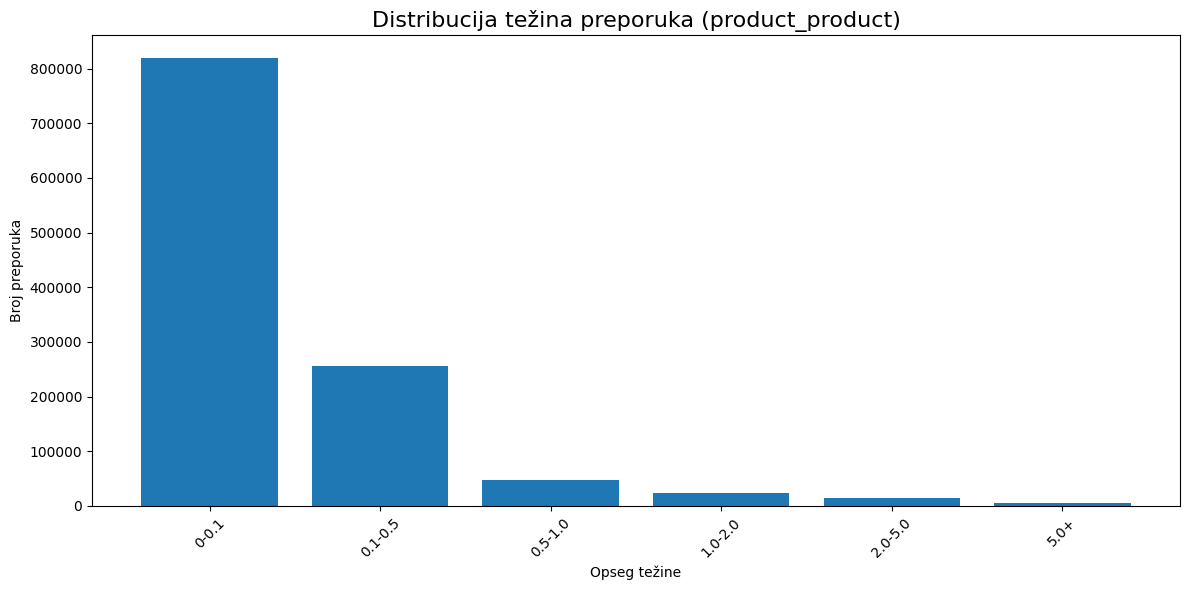

In [14]:
from pyspark.sql.functions import avg, min as spark_min, max as spark_max, count as spark_count

# DataFrame API
weight_stats_df = product_product_df.agg(
    spark_count("*").alias("total"),
    avg("interaction_weight").alias("avg_weight"),
    spark_min("interaction_weight").alias("min_weight"),
    spark_max("interaction_weight").alias("max_weight")
)

print("=== DataFrame API: Statistike težina ===")
weight_stats_df.show()

# Bucketing sa when/otherwise
weight_buckets_df = product_product_df.withColumn("bucket",
    when(col("interaction_weight") < 0.1, "0-0.1")
    .when(col("interaction_weight") < 0.5, "0.1-0.5")
    .when(col("interaction_weight") < 1.0, "0.5-1.0")
    .when(col("interaction_weight") < 2.0, "1.0-2.0")
    .when(col("interaction_weight") < 5.0, "2.0-5.0")
    .otherwise("5.0+")
).groupBy("bucket").agg(
    count("*").alias("count"),
    avg("interaction_weight").alias("avg_weight")
).orderBy("bucket")

print("=== DataFrame API: Bucketed ===")
weight_buckets_df.show()

# SparkSQL
print("=== SparkSQL ===")
spark.sql("""
    SELECT 
        CASE 
            WHEN interaction_weight < 0.1 THEN '0-0.1'
            WHEN interaction_weight < 0.5 THEN '0.1-0.5'
            WHEN interaction_weight < 1.0 THEN '0.5-1.0'
            WHEN interaction_weight < 2.0 THEN '1.0-2.0'
            WHEN interaction_weight < 5.0 THEN '2.0-5.0'
            ELSE '5.0+'
        END as bucket,
        COUNT(*) as count,
        AVG(interaction_weight) as avg_weight
    FROM product_product
    GROUP BY bucket
    ORDER BY bucket
""").show()

# Vizualizacija
pdf_buckets = weight_buckets_df.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(pdf_buckets['bucket'], pdf_buckets['count'])
plt.title('Distribucija težina preporuka (product_product)', fontsize=16)
plt.xlabel('Opseg težine')
plt.ylabel('Broj preporuka')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.8 Mesečna analiza interakcija

=== DataFrame API ===
+----------+------------------+------------+---------------+-----------+
|year_month|total_interactions|unique_users|unique_products|add_to_cart|
+----------+------------------+------------+---------------+-----------+
|2025-06   |106652            |64724       |18577          |2250       |
|2025-07   |270051            |122681      |30947          |4794       |
|2025-08   |210406            |69974       |25589          |4934       |
|2025-09   |144948            |52359       |21669          |4510       |
+----------+------------------+------------+---------------+-----------+

=== SparkSQL ===
+----------+------------------+------------+---------------+-----------+
|year_month|total_interactions|unique_users|unique_products|add_to_cart|
+----------+------------------+------------+---------------+-----------+
|2025-06   |106652            |64724       |18577          |2250       |
|2025-07   |270051            |122681      |30947          |4794       |
|2025-08   

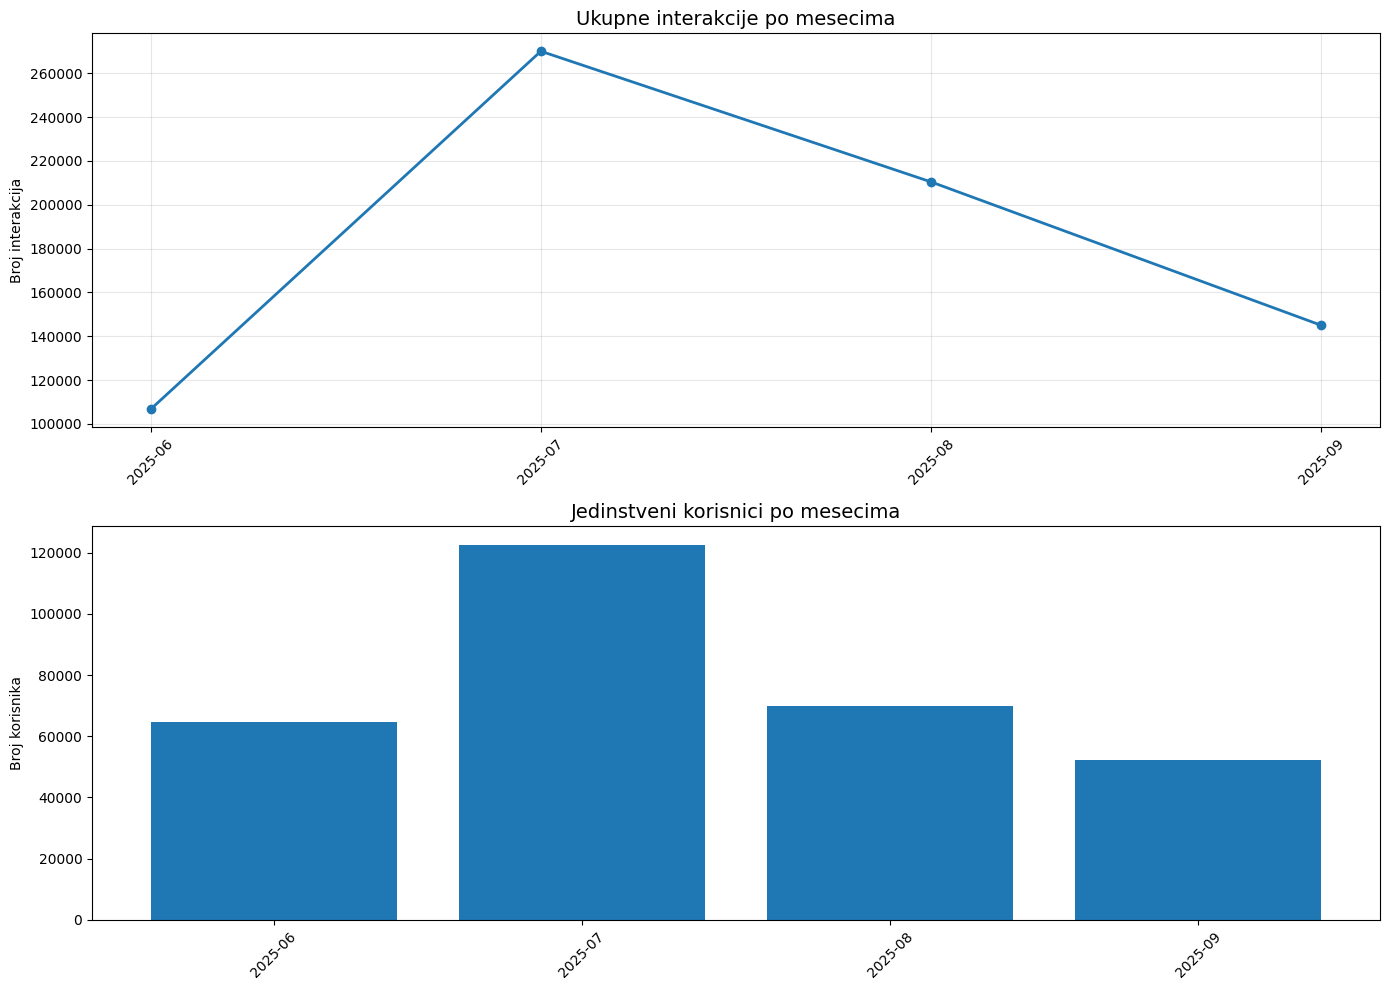

Najaktivniji mesec: 2025-07 (270,051 interakcija)


In [15]:
# DataFrame API
monthly_df = interactions_df \
    .withColumn("year_month", date_format(from_unixtime(col("created")), "yyyy-MM")) \
    .groupBy("year_month").agg(
        count("*").alias("total_interactions"),
        countDistinct("user_uid").alias("unique_users"),
        countDistinct("product_id").alias("unique_products"),
        spark_sum(when(col("action") == "add_to_cart", 1).otherwise(0)).alias("add_to_cart")
    ).orderBy("year_month")

print("=== DataFrame API ===")
monthly_df.show(truncate=False)

# SparkSQL
print("=== SparkSQL ===")
spark.sql("""
    SELECT 
        DATE_FORMAT(FROM_UNIXTIME(created), 'yyyy-MM') as year_month,
        COUNT(*) as total_interactions,
        COUNT(DISTINCT user_uid) as unique_users,
        COUNT(DISTINCT product_id) as unique_products,
        SUM(CASE WHEN action = 'add_to_cart' THEN 1 ELSE 0 END) as add_to_cart
    FROM interactions
    GROUP BY DATE_FORMAT(FROM_UNIXTIME(created), 'yyyy-MM')
    ORDER BY year_month
""").show(truncate=False)

# Vizualizacija - dual subplot
pdf_monthly = monthly_df.toPandas()
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(pdf_monthly['year_month'], pdf_monthly['total_interactions'], marker='o', linewidth=2)
axes[0].set_title('Ukupne interakcije po mesecima', fontsize=14)
axes[0].set_ylabel('Broj interakcija')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(pdf_monthly['year_month'], pdf_monthly['unique_users'])
axes[1].set_title('Jedinstveni korisnici po mesecima', fontsize=14)
axes[1].set_ylabel('Broj korisnika')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

best = pdf_monthly.loc[pdf_monthly['total_interactions'].idxmax()]
print(f"Najaktivniji mesec: {best['year_month']} ({best['total_interactions']:,} interakcija)")

---
## Sekcija 4: Poređenje Pandas vs Spark

In [12]:
import pandas as pd
import numpy as np
import time
from pyspark.sql.functions import count, countDistinct, col
from pyspark.sql.functions import min as spark_min, max as spark_max

# Učitaj iste podatke u Pandas
pdf_interactions = pd.read_csv(os.path.join(DATA_DIR, 'filtered_interactions.csv'))
pdf_interactions['product_id'] = pdf_interactions['product_id'].astype('Int64')

print("=" * 65)
print("TEST 1: Jednostavan groupBy + count (Pandas pobednik)")
print("=" * 65)

# Pandas
start = time.time()
pandas_result = pdf_interactions.groupby('action').size().reset_index(name='count').sort_values('count', ascending=False)
pandas_time_simple = time.time() - start

# Spark
start = time.time()
spark_result = interactions_df.groupBy('action').agg(count('*').alias('count')).orderBy(col('count').desc()).collect()
spark_time_simple = time.time() - start

print(f"  Pandas: {pandas_time_simple:.4f}s")
print(f"  Spark:  {spark_time_simple:.4f}s")
print(f"  -> Pandas {spark_time_simple/pandas_time_simple:.1f}x brži (mali dataset, nema paralelizacije)")

print()
print("=" * 65)
print("TEST 2: Self-join po korisniku (Spark pobednik)")
print("  Simulacija cross-sell pipeline-a: pronalaženje svih parova")
print("  proizvoda koje je isti korisnik pogledao")
print("=" * 65)

# Pandas self-join
start = time.time()
pdf_subset = pdf_interactions[['user_uid', 'product_id', 'created']].copy()
pdf_merged = pdf_subset.merge(pdf_subset, on='user_uid', suffixes=('_l', '_r'))
pdf_merged = pdf_merged[pdf_merged['product_id_l'] < pdf_merged['product_id_r']]
pdf_pairs = pdf_merged.groupby(['product_id_l', 'product_id_r']).size().reset_index(name='co_count')
pandas_pairs_count = len(pdf_pairs)
pandas_time_join = time.time() - start

# Spark self-join
start = time.time()
spark_subset = interactions_df.select('user_uid', 'product_id', 'created')
spark_merged = spark_subset.alias('l').join(
    spark_subset.alias('r'), 'user_uid'
).filter(col('l.product_id') < col('r.product_id'))
spark_pairs = spark_merged.groupBy(
    col('l.product_id').alias('product_l'),
    col('r.product_id').alias('product_r')
).agg(count('*').alias('co_count'))
spark_pairs_count = spark_pairs.count()
spark_time_join = time.time() - start

print(f"  Pandas: {pandas_time_join:.2f}s ({pandas_pairs_count:,} parova)")
print(f"  Spark:  {spark_time_join:.2f}s ({spark_pairs_count:,} parova)")
if spark_time_join < pandas_time_join:
    print(f"  -> Spark {pandas_time_join/spark_time_join:.1f}x brži (self-join se paralelizuje na {spark.sparkContext.defaultParallelism} jezgara)")
else:
    print(f"  -> Spark sporiji za {spark_time_join - pandas_time_join:.1f}s (dataset premali za prednost)")

print()
print("=" * 65)
print("TEST 3: Višestruke teške agregacije odjednom")
print("=" * 65)

# Pandas - sekvencijalno
start = time.time()
for _ in range(5):
    _ = pdf_interactions.groupby('user_uid').agg(
        total=('id', 'count'),
        unique_products=('product_id', 'nunique'),
        first_ts=('created', 'min'),
        last_ts=('created', 'max')
    )
    _ = pdf_interactions.groupby('product_id').agg(
        total=('id', 'count'),
        unique_users=('user_uid', 'nunique')
    )
pandas_time_agg = time.time() - start

# Spark - keširan, paralelno
interactions_df.cache()
interactions_df.count()  # materijalizuj keš
start = time.time()
for _ in range(5):
    _ = interactions_df.groupBy('user_uid').agg(
        count('*').alias('total'),
        countDistinct('product_id').alias('unique_products'),
        spark_min('created').alias('first_ts'),
        spark_max('created').alias('last_ts')
    ).collect()
    _ = interactions_df.groupBy('product_id').agg(
        count('*').alias('total'),
        countDistinct('user_uid').alias('unique_users')
    ).collect()
spark_time_agg = time.time() - start
interactions_df.unpersist()

print(f"  Pandas (5x sekvencijalno): {pandas_time_agg:.2f}s")
print(f"  Spark  (5x sa cache):      {spark_time_agg:.2f}s")
if spark_time_agg < pandas_time_agg:
    print(f"  -> Spark {pandas_time_agg/spark_time_agg:.1f}x brži (cache + paralelne agregacije)")
else:
    print(f"  -> Pandas brži za ovaj obim podataka")

print()
print("ZAKLJUČAK:")
print("  - Pandas: brži za proste operacije na malom datasetu (<1M redova)")
print("  - Spark:  brži za teške operacije (join, multi-agg) i skalira na klaster")

TEST 1: Jednostavan groupBy + count (Pandas pobednik)
  Pandas: 0.0359s
  Spark:  0.9682s
  -> Pandas 27.0x brži (mali dataset, nema paralelizacije)

TEST 2: Self-join po korisniku (Spark pobednik)
  Simulacija cross-sell pipeline-a: pronalaženje svih parova
  proizvoda koje je isti korisnik pogledao
  Pandas: 11.72s (8,779,822 parova)
  Spark:  7.88s (8,779,822 parova)
  -> Spark 1.5x brži (self-join se paralelizuje na 12 jezgara)

TEST 3: Višestruke teške agregacije odjednom
  Pandas (5x sekvencijalno): 8.10s
  Spark  (5x sa cache):      12.63s
  -> Pandas brži za ovaj obim podataka

ZAKLJUČAK:
  - Pandas: brži za proste operacije na malom datasetu (<1M redova)
  - Spark:  brži za teške operacije (join, multi-agg) i skalira na klaster


In [13]:
# Tabela sintaksnog poređenja Pandas vs PySpark
comparison = {
    'Operacija': ['Selekcija kolona', 'Filter', 'Nova kolona', 'Sortiranje', 'Agregacija', 'Join'],
    'Pandas': [
        "df[['col1', 'col2']]",
        "df[df['col'] > 5]",
        "df['new'] = df['a'] + df['b']",
        "df.sort_values('col')",
        "df.groupby('col').agg({'val': 'sum'})",
        "pd.merge(df1, df2, on='key')"
    ],
    'PySpark': [
        "df.select('col1', 'col2')",
        "df.filter(col('col') > 5)",
        "df.withColumn('new', col('a') + col('b'))",
        "df.orderBy('col')",
        "df.groupBy('col').agg(sum('val'))",
        "df1.join(df2, 'key')"
    ]
}

pdf_compare = pd.DataFrame(comparison)
print("=== Sintaksno poređenje: Pandas vs PySpark ===")
print(pdf_compare.to_string(index=False))

print("\nKljučne razlike:")
print("  - PySpark DataFrame je immutable (withColumn vraća novi DF)")
print("  - PySpark koristi lazy evaluation (transformacije se ne izvršavaju dok nema action-a)")
print("  - PySpark podržava distribuiranu obradu na klasteru")
print("  - Pandas je brži za male datasetove na jednoj mašini")

=== Sintaksno poređenje: Pandas vs PySpark ===
       Operacija                                Pandas                                   PySpark
Selekcija kolona                  df[['col1', 'col2']]                 df.select('col1', 'col2')
          Filter                     df[df['col'] > 5]                 df.filter(col('col') > 5)
     Nova kolona         df['new'] = df['a'] + df['b'] df.withColumn('new', col('a') + col('b'))
      Sortiranje                 df.sort_values('col')                         df.orderBy('col')
      Agregacija df.groupby('col').agg({'val': 'sum'})         df.groupBy('col').agg(sum('val'))
            Join          pd.merge(df1, df2, on='key')                      df1.join(df2, 'key')

Ključne razlike:
  - PySpark DataFrame je immutable (withColumn vraća novi DF)
  - PySpark koristi lazy evaluation (transformacije se ne izvršavaju dok nema action-a)
  - PySpark podržava distribuiranu obradu na klasteru
  - Pandas je brži za male datasetove na jednoj maši

---
## Sekcija 5: SparkML Priprema Podataka

Repliciramo pipeline iz `shared.py`: težine interakcija, vremenski decay, repeat decay, threshold filtriranje.

In [18]:
from pyspark.sql.functions import lit, exp, current_timestamp, unix_timestamp, datediff
from pyspark.sql.functions import col, when, count, sum as spark_sum
from pyspark.sql.functions import pow as spark_pow

# Korak 1: Težine interakcija (shared.py:38-44 INTERACTION_WEIGHTS)
# Mapiranje akcije -> bazična težina koristeći when/otherwise
weighted_df = interactions_df.withColumn("base_weight",
    when(col("action") == "purchase", 1.0)
    .when(col("action") == "initiate_checkout", 0.7)
    .when(col("action") == "add_to_cart", 0.5)
    .when(col("action") == "add_to_wishlist", 0.3)
    .when(col("action") == "content_view", 0.1)
    .otherwise(0.0)
)

print("Korak 1: Bazične težine interakcija")
weighted_df.groupBy("action", "base_weight").count().orderBy(col("base_weight").desc()).show()

Korak 1: Bazične težine interakcija
+-----------------+-----------+------+
|           action|base_weight| count|
+-----------------+-----------+------+
|         purchase|        1.0|  2581|
|initiate_checkout|        0.7|  7840|
|      add_to_cart|        0.5| 16488|
|  add_to_wishlist|        0.3|   607|
|     content_view|        0.1|704541|
+-----------------+-----------+------+



In [19]:
# Korak 2: Vremenski decay (shared.py:134-149)
# Formula: base_weight * exp(-days_since / DECAY_SCALE)
# DECAY_SCALE = 25
now_unix = time.time()

decayed_df = weighted_df.withColumn(
    "days_since", (lit(now_unix) - col("created")) / 86400.0
).withColumn(
    "individual_rating", col("base_weight") * exp(-col("days_since") / lit(DECAY_SCALE))
)

print("Korak 2: Vremenski decay")
print(f"  Formula: base_weight * exp(-days_since / {DECAY_SCALE})")
decayed_df.select("action", "base_weight", "days_since", "individual_rating") \
    .summary("count", "mean", "min", "max").show()

decayed_df.select("user_uid", "product_id", "action", "base_weight", "days_since", "individual_rating").show(5, truncate=20)

Korak 2: Vremenski decay
  Formula: base_weight * exp(-days_since / 25)
+-------+-----------+-------------------+------------------+--------------------+
|summary|     action|        base_weight|        days_since|   individual_rating|
+-------+-----------+-------------------+------------------+--------------------+
|  count|     732057|             732057|            732057|              732057|
|   mean|       NULL|0.11877381132892528| 208.6883486107108| 5.09263221905499E-5|
|    min|add_to_cart|                0.1|159.11557764116813|3.716822088845104E-6|
|    max|   purchase|                1.0| 259.1944202337607|0.001719213460033...|
+-------+-----------+-------------------+------------------+--------------------+

+--------------------+----------+-----------+-----------+------------------+--------------------+
|            user_uid|product_id|     action|base_weight|        days_since|   individual_rating|
+--------------------+----------+-----------+-----------+------------------

In [20]:
# Korak 3: Grupacija + repeat decay (shared.py:81-89, 151-153)
# GroupBy(user, product) -> sum(individual_rating), count
# Zatim: total_rating * REPEAT_DECAY_FACTOR ^ (interaction_count - 1)
grouped_df = decayed_df.groupBy("user_uid", "product_id").agg(
    spark_sum("individual_rating").alias("total_rating"),
    count("*").alias("interaction_count")
)

# Apply repeat decay: total_rating * 0.8^(count - 1)
grouped_df = grouped_df.withColumn(
    "rating",
    col("total_rating") * spark_pow(lit(REPEAT_DECAY_FACTOR), col("interaction_count") - 1)
)

print(f"Korak 3: Grupisane interakcije: {grouped_df.count():,} (user, product) parova")
print(f"  Repeat decay factor: {REPEAT_DECAY_FACTOR}")
grouped_df.select("total_rating", "interaction_count", "rating").summary("count", "mean", "min", "max").show()

Korak 3: Grupisane interakcije: 555,101 (user, product) parova
  Repeat decay factor: 0.8
+-------+--------------------+------------------+--------------------+
|summary|        total_rating| interaction_count|              rating|
+-------+--------------------+------------------+--------------------+
|  count|              555101|            555101|              555101|
|   mean|6.716069804206363E-5|1.3187816271273156|5.143562642385807E-5|
|    min|3.717116348908108...|                 1|4.093110048633673...|
|    max| 0.02848961125653793|               115|0.002442843949940...|
+-------+--------------------+------------------+--------------------+



In [21]:
from pyspark.ml.feature import StringIndexer

# Korak 4: Threshold filtriranje (shared.py:672-681)
# Korisnici sa > 2 interakcije, Proizvodi sa > 4 interakcije
user_counts = grouped_df.groupBy("user_uid").agg(
    spark_sum("interaction_count").alias("user_total")
).filter(col("user_total") > 2)

product_counts = grouped_df.groupBy("product_id").agg(
    spark_sum("interaction_count").alias("product_total")
).filter(col("product_total") > 4)

filtered_df = grouped_df \
    .join(user_counts.select("user_uid"), "user_uid", "inner") \
    .join(product_counts.select("product_id"), "product_id", "inner")

print(f"Korak 4: Threshold filtriranje")
print(f"  Pre filtriranja:  {grouped_df.count():,} parova")
print(f"  Posle filtriranja: {filtered_df.count():,} parova")
print(f"  Korisnici (>2 interakcije): {user_counts.count():,}")
print(f"  Proizvodi (>4 interakcije): {product_counts.count():,}")

# Korak 5: StringIndexer za user_uid (base64 string -> numerički indeks)
# SparkML ALS zahteva numeričke user/item ID-jeve
user_indexer = StringIndexer(inputCol="user_uid", outputCol="user_index")
user_indexer_model = user_indexer.fit(filtered_df)
als_data = user_indexer_model.transform(filtered_df)

# product_id je već integer
als_data = als_data.withColumn("user_index", col("user_index").cast(IntegerType()))

print(f"\nKorak 5: StringIndexer")
print(f"  Jedinstvenih korisnika: {als_data.select('user_index').distinct().count()}")
print(f"  Jedinstvenih proizvoda: {als_data.select('product_id').distinct().count()}")
als_data.select("user_uid", "user_index", "product_id", "rating").show(5, truncate=20)

Korak 4: Threshold filtriranje
  Pre filtriranja:  555,101 parova
  Posle filtriranja: 279,807 parova
  Korisnici (>2 interakcije): 50,459
  Proizvodi (>4 interakcije): 20,354

Korak 5: StringIndexer
  Jedinstvenih korisnika: 50195
  Jedinstvenih proizvoda: 20164
+--------------------+----------+----------+--------------------+
|            user_uid|user_index|product_id|              rating|
+--------------------+----------+----------+--------------------+
|M012NmdXNkNSekxpd...|     43855|     12104|1.515205745960575E-4|
|M01LSE9IQXhYdnB1M...|     21916|     39015|1.105304208909246...|
|M01LSE9IQXhYdnB1M...|     21916|     42401|1.105308814353045E-4|
|M01LSE9IQXhYdnB1M...|     21916|        71|1.105279135162983...|
|M01Xak9XMU44YTZBd...|     11717|     97765|9.284200881910299E-5|
+--------------------+----------+----------+--------------------+
only showing top 5 rows



---
## Sekcija 6: SparkML ALS Trening

**Produkcijski parametri** (`als.py:64`): factors=800, reg=0.005, alpha=800.0, iter=35

**Lokalni parametri** (smanjeni za lokalnu mašinu):
- rank=100 (umesto 800) - manje latentnih faktora
- alpha=40.0 (umesto 800) - manji confidence scaling
- maxIter=20 (umesto 35) - manje iteracija

In [22]:
from pyspark.ml.recommendation import ALS

# Train/test split 80/20
train_data, test_data = als_data.randomSplit([0.8, 0.2], seed=42)

print(f"Train set: {train_data.count():,} redova")
print(f"Test set:  {test_data.count():,} redova")
print(f"Odnos:     {train_data.count()/(train_data.count()+test_data.count())*100:.1f}% / {test_data.count()/(train_data.count()+test_data.count())*100:.1f}%")

Train set: 224,065 redova
Test set:  55,742 redova
Odnos:     80.1% / 19.9%


In [23]:
# SparkML ALS model
als = ALS(
    rank=100,               # Latentni faktori (produkcija: 800)
    maxIter=20,             # Iteracije (produkcija: 35)
    regParam=0.005,         # Regularizacija (isto kao produkcija)
    alpha=40.0,             # Confidence scaling (produkcija: 800)
    implicitPrefs=True,     # Implicit feedback mode
    userCol="user_index",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop",  # Drop NaN predikcije za cold-start korisnike/proizvode
    nonnegative=True,       # Non-negative faktorizacija
    seed=42
)

print("Treniranje ALS modela...")
start_time = time.time()
als_model = als.fit(train_data)
train_time = time.time() - start_time

print(f"Model istreniran za {train_time:.1f}s")
print(f"\nParametri:")
print(f"  rank (latentni faktori): {als.getRank()}")
print(f"  maxIter:                 {als.getMaxIter()}")
print(f"  regParam:                {als.getRegParam()}")
print(f"  alpha:                   {als.getAlpha()}")
print(f"  implicitPrefs:           {als.getImplicitPrefs()}")
print(f"  nonnegative:             {als.getNonnegative()}")

Treniranje ALS modela...
Model istreniran za 97.1s

Parametri:
  rank (latentni faktori): 100
  maxIter:                 20
  regParam:                0.005
  alpha:                   40.0
  implicitPrefs:           True
  nonnegative:             True


---
## Sekcija 7: Evaluacija Modela

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator

# Predikcije na test setu
predictions = als_model.transform(test_data)

# RMSE
rmse_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = rmse_evaluator.evaluate(predictions)

# MAE
mae_evaluator = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)
mae = mae_evaluator.evaluate(predictions)

print("=== Regression Metrike na Test Setu ===")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")

print("\nPrimer predikcija:")
predictions.select("user_index", "product_id", "rating", "prediction").show(10)

=== Regression Metrike na Test Setu ===
  RMSE: 0.077687
  MAE:  0.026107

Primer predikcija:
+----------+----------+--------------------+------------+
|user_index|product_id|              rating|  prediction|
+----------+----------+--------------------+------------+
|         6|       362|2.718265840065198...| 0.004761193|
|         6|       818|1.757134568080001...| 0.007611862|
|         6|      1762|1.757607268310243E-5|  0.00478943|
|         6|      1886|2.141355469721699E-5|6.6879037E-4|
|         6|      2990|1.757264731016946...| 0.017402567|
|         6|      3636|1.756716484877988...|0.0056333775|
|         6|      4684|6.066431294609771...|0.0016843567|
|         6|      5884|1.994612256358469...| 0.016024437|
|         6|      6791| 4.00724595529027E-6|2.3019487E-5|
|         6|      8058|1.756621331978805E-5|  0.02493538|
+----------+----------+--------------------+------------+
only showing top 10 rows



In [25]:
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import collect_list, expr, array
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc

K = 10

# Ground truth: pravi (relevantni) proizvodi po korisniku iz test seta
ground_truth = test_data \
    .filter(col("rating") > 0) \
    .groupBy("user_index") \
    .agg(collect_list(col("product_id").cast(DoubleType())).alias("label"))

# Top-K predikcije po korisniku
window_spec = Window.partitionBy("user_index").orderBy(desc("prediction"))
top_k_predictions = predictions \
    .withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") <= K) \
    .groupBy("user_index") \
    .agg(collect_list(col("product_id").cast(DoubleType())).alias("prediction"))

# Join ground truth sa predikcijama
ranking_data = top_k_predictions.join(ground_truth, "user_index", "inner")

print(f"Korisnika za ranking evaluaciju: {ranking_data.count()}")

# Precision@K
precision_evaluator = RankingEvaluator(
    predictionCol="prediction",
    labelCol="label",
    metricName="precisionAtK",
    k=K
)
precision_at_k = precision_evaluator.evaluate(ranking_data)

# NDCG@K
ndcg_evaluator = RankingEvaluator(
    predictionCol="prediction",
    labelCol="label",
    metricName="ndcgAtK",
    k=K
)
ndcg_at_k = ndcg_evaluator.evaluate(ranking_data)

# MAP@K
map_evaluator = RankingEvaluator(
    predictionCol="prediction",
    labelCol="label",
    metricName="meanAveragePrecisionAtK",
    k=K
)
map_at_k = map_evaluator.evaluate(ranking_data)

print(f"\n=== Ranking Metrike @{K} ===")
print(f"  Precision@{K}: {precision_at_k:.6f}")
print(f"  NDCG@{K}:      {ndcg_at_k:.6f}")
print(f"  MAP@{K}:       {map_at_k:.6f}")

Korisnika za ranking evaluaciju: 25111

=== Ranking Metrike @10 ===
  Precision@10: 0.191960
  NDCG@10:      0.998310
  MAP@10:       0.997701


In [26]:
# Generisanje preporuka za sve korisnike
print("Generisanje Top-10 preporuka za sve korisnike...")
start_time = time.time()
user_recs = als_model.recommendForAllUsers(10)
rec_time = time.time() - start_time
print(f"Generisano za {rec_time:.1f}s")

# Primer preporuka za prvog korisnika
print("\nPrimer preporuka (prvi korisnik):")
user_recs.show(1, truncate=False)

# Top 20 najčešće preporučivanih proizvoda
from pyspark.sql.functions import explode

all_recs_flat = user_recs.select(
    "user_index",
    explode("recommendations").alias("rec")
).select(
    "user_index",
    col("rec.product_id").alias("product_id"),
    col("rec.rating").alias("score")
)

top_recommended = all_recs_flat.groupBy("product_id") \
    .agg(
        count("*").alias("times_recommended"),
        avg("score").alias("avg_score")
    ).orderBy(col("times_recommended").desc()).limit(20)

print("\nTop 20 najčešće preporučivanih proizvoda:")
top_recommended.show(20)

Generisanje Top-10 preporuka za sve korisnike...
Generisano za 0.1s

Primer preporuka (prvi korisnik):
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                                                        |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|12        |[{9482, 1.7199818}, {43035, 1.6766635}, {12600, 1.5238714}, {89238, 1.4722478}, {83811, 1.140609}, {12968, 1.1394733}, {552, 0.94430286}, {12314, 0.92449296}, {90219, 0.86580545}, {76331, 0.8510331}]|
+----------+---------------------------------

---
## Sekcija 8: Poređenje i Zaključci

In [27]:
# Tabela poređenja: SparkML ALS vs implicit ALS
comparison_data = {
    'Karakteristika': [
        'Biblioteka',
        'Latentni faktori',
        'Regularizacija',
        'Alpha (confidence)',
        'Iteracije',
        'BM25 weighting',
        'GPU podrška',
        'Distribuirana obrada',
        'Cold-start strategija',
        'Non-negative',
        'Optimalan za'
    ],
    'Produkcija (implicit)': [
        'implicit (Python)',
        '800',
        '0.005',
        '800.0',
        '35',
        'Da (K1=1.2, B=0.3)',
        'Da (CUDA)',
        'Ne (single machine)',
        'N/A',
        'N/A',
        'Single GPU, <10M interakcija'
    ],
    'Ovaj notebook (SparkML)': [
        'pyspark.ml.recommendation.ALS',
        '100 (smanjeno za lokalno)',
        '0.005',
        '40.0 (smanjeno za lokalno)',
        '20 (smanjeno za lokalno)',
        'Ne (manuelni decay)',
        'Ne',
        'Da (klaster)',
        'drop',
        'Da',
        'Klaster, >100M interakcija'
    ]
}

pdf_comp = pd.DataFrame(comparison_data)
print("=== SparkML ALS vs implicit ALS ===")
print(pdf_comp.to_string(index=False))

print("\nKljučne razlike:")
print("  1. implicit koristi BM25 weighting pre ALS treninga (poboljšava metrike za ~100%)")
print("  2. implicit podržava GPU ubrzanje (NVIDIA CUDA)")
print("  3. SparkML se prirodno skalira na Spark klasteru")
print("  4. SparkML ima ugrađenu cold-start strategiju (drop)")
print("  5. Za naš dataset (~732K interakcija), implicit je efikasniji")
print("  6. Za >100M interakcija na klasteru, SparkML je bolji izbor")

=== SparkML ALS vs implicit ALS ===
       Karakteristika        Produkcija (implicit)       Ovaj notebook (SparkML)
           Biblioteka            implicit (Python) pyspark.ml.recommendation.ALS
     Latentni faktori                          800     100 (smanjeno za lokalno)
       Regularizacija                        0.005                         0.005
   Alpha (confidence)                        800.0    40.0 (smanjeno za lokalno)
            Iteracije                           35      20 (smanjeno za lokalno)
       BM25 weighting           Da (K1=1.2, B=0.3)           Ne (manuelni decay)
          GPU podrška                    Da (CUDA)                            Ne
 Distribuirana obrada          Ne (single machine)                  Da (klaster)
Cold-start strategija                          N/A                          drop
         Non-negative                          N/A                            Da
         Optimalan za Single GPU, <10M interakcija    Klaster, >100M inte

In [28]:
# Kompleksan SparkSQL upit: CTE + RANK() OVER + conversion analysis
print("=== Kompleksna SparkSQL analiza: Konverzija po kategorijama aktivnosti ===")

spark.sql("""
    WITH user_stats AS (
        SELECT 
            user_uid,
            COUNT(*) as total_interactions,
            COUNT(DISTINCT product_id) as unique_products,
            MAX(CASE WHEN action = 'purchase' THEN 1 ELSE 0 END) as has_purchase,
            MAX(CASE WHEN action = 'add_to_cart' THEN 1 ELSE 0 END) as has_cart,
            MIN(created) as first_interaction,
            MAX(created) as last_interaction
        FROM interactions
        GROUP BY user_uid
    ),
    ranked_users AS (
        SELECT 
            *,
            RANK() OVER (ORDER BY total_interactions DESC) as activity_rank,
            CASE 
                WHEN total_interactions >= 100 THEN 'Power User'
                WHEN total_interactions >= 20 THEN 'Aktivan'
                WHEN total_interactions >= 5 THEN 'Umereni'
                ELSE 'Neaktivan'
            END as segment,
            (last_interaction - first_interaction) / 86400.0 as active_days
        FROM user_stats
    )
    SELECT 
        segment,
        COUNT(*) as user_count,
        ROUND(AVG(total_interactions), 1) as avg_interactions,
        ROUND(AVG(unique_products), 1) as avg_unique_products,
        SUM(has_purchase) as purchasers,
        ROUND(SUM(has_purchase) / COUNT(*) * 100, 2) as purchase_rate_pct,
        SUM(has_cart) as cart_users,
        ROUND(AVG(active_days), 1) as avg_active_days
    FROM ranked_users
    GROUP BY segment
    ORDER BY avg_interactions DESC
""").show(truncate=False)

=== Kompleksna SparkSQL analiza: Konverzija po kategorijama aktivnosti ===
+----------+----------+----------------+-------------------+----------+-----------------+----------+---------------+
|segment   |user_count|avg_interactions|avg_unique_products|purchasers|purchase_rate_pct|cart_users|avg_active_days|
+----------+----------+----------------+-------------------+----------+-----------------+----------+---------------+
|Power User|305       |235.3           |142.3              |69        |22.62            |162       |58.6           |
|Aktivan   |3540      |36.2            |22.1               |493       |13.93            |1204      |37.9           |
|Umereni   |22377     |8.3             |5.5                |1352      |6.04             |3133      |19.0           |
|Neaktivan |256339    |1.3             |1.2                |426       |0.17             |1642      |1.5            |
+----------+----------+----------------+-------------------+----------+-----------------+----------+------

In [29]:
# Vizuelni summary svih metrika
print("=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nDataset:")
print(f"  Interakcije:    {interactions_df.count():,}")
print(f"  Proizvodi:      {products_df.count():,}")
print(f"  Product-Product: {product_product_df.count():,}")
print(f"\nALS Model (SparkML):")
print(f"  RMSE:           {rmse:.6f}")
print(f"  MAE:            {mae:.6f}")
print(f"  Precision@{K}:  {precision_at_k:.6f}")
print(f"  NDCG@{K}:       {ndcg_at_k:.6f}")
print(f"  MAP@{K}:        {map_at_k:.6f}")
print(f"  Vreme treniranja: {train_time:.1f}s")
print(f"  Vreme preporuka:  {rec_time:.1f}s")
print("=" * 60)

SUMMARY

Dataset:
  Interakcije:    732,057
  Proizvodi:      268,769
  Product-Product: 1,165,379

ALS Model (SparkML):
  RMSE:           0.077687
  MAE:            0.026107
  Precision@10:  0.191960
  NDCG@10:       0.998310
  MAP@10:        0.997701
  Vreme treniranja: 97.1s
  Vreme preporuka:  0.1s


In [30]:
# Cleanup
spark.stop()
print("Spark sesija zatvorena.")

Spark sesija zatvorena.
